Custom-CNN

In [1]:
!pip install torchinfo

In [2]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.5 MB/s 

### Import Libraries

In [3]:
import os
import time
import platform
import psutil
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from PIL import Image
import PIL

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from torchvision import transforms


In [4]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

### Configuration

In [5]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [6]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [7]:
data_dir = "/kaggle/input/dataset-for-cotton-leaf-disease-detection/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Augmented Dataset/Augmented Dataset"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
#df['label'] = df['label'].str.strip()
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
label_map = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}
num_classes = len(label_map)

Class: Leaf Hopper Jassids, Count: 1000
Class: Leaf Redding, Count: 1000
Class: Healthy Leaf, Count: 1000
Class: Herbicide Growth Damage, Count: 1000
Class: Bacterial Blight, Count: 1000
Class: Leaf Variegation, Count: 1000
Class: Curl Virus, Count: 1000


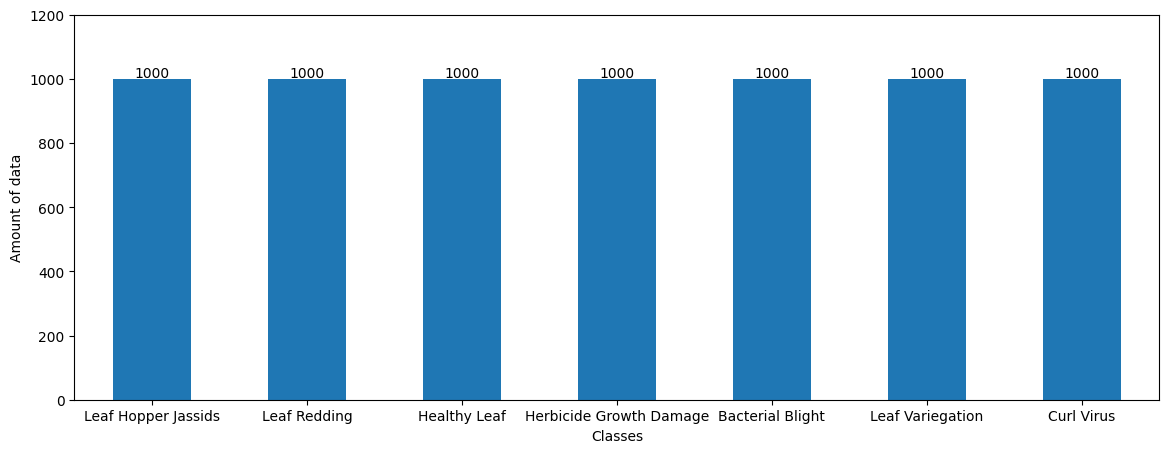

In [9]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(14, 5))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

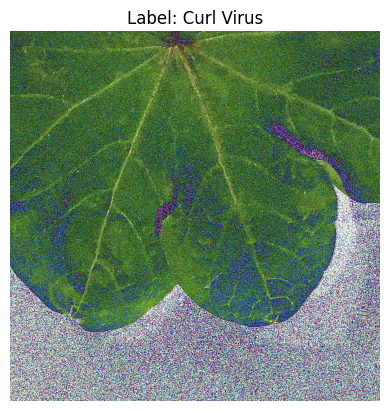

In [10]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [11]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [12]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  4900
Validation Data:  1050
Test Data:  1050
-------------------------------------------
Total amounts of data in the dataset:  7000


In [13]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                      Count
-----------------------  -------
Healthy Leaf                 700
Curl Virus                   700
Bacterial Blight             700
Leaf Redding                 700
Leaf Hopper Jassids          700
Leaf Variegation             700
Herbicide Growth Damage      700

Validation Dataset
Class                      Count
-----------------------  -------
Leaf Variegation             150
Leaf Hopper Jassids          150
Healthy Leaf                 150
Herbicide Growth Damage      150
Curl Virus                   150
Bacterial Blight             150
Leaf Redding                 150

Test Dataset
Class                      Count
-----------------------  -------
Bacterial Blight             150
Leaf Redding                 150
Healthy Leaf                 150
Herbicide Growth Damage      150
Leaf Hopper Jassids          150
Leaf Variegation             150
Curl Virus                   150


### Device Variable

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [15]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Dataset Class, Dataloader and Transform

In [16]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [17]:
train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

### Custom-CNN

In [18]:
# Custom CNN Model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # 128x128x3 → 128x128x16
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # → 64x64x16

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # → 64x64x32
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # → 32x32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # → 32x32x64
            nn.ReLU(),
            nn.AvgPool2d(2, 2),                          # → 16x16x64
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                # → 16*16*64 = 16384
            nn.Linear(64 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



Model setup block

In [19]:
# Setup for Custom CNN Model
num_classes = len(label_map)  
learning_rate = 0.0001

# Initialize the custom model
model = CustomCNN(num_classes=num_classes).to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Model summary using 128x128 input size
summary(model, input_size=(train_batch, 3, 128, 128))


Layer (type:depth-idx)                   Output Shape              Param #
CustomCNN                                [32, 7]                   --
├─Sequential: 1-1                        [32, 64, 16, 16]          --
│    └─Conv2d: 2-1                       [32, 16, 128, 128]        448
│    └─ReLU: 2-2                         [32, 16, 128, 128]        --
│    └─MaxPool2d: 2-3                    [32, 16, 64, 64]          --
│    └─Conv2d: 2-4                       [32, 32, 64, 64]          4,640
│    └─ReLU: 2-5                         [32, 32, 64, 64]          --
│    └─MaxPool2d: 2-6                    [32, 32, 32, 32]          --
│    └─Conv2d: 2-7                       [32, 64, 32, 32]          18,496
│    └─ReLU: 2-8                         [32, 64, 32, 32]          --
│    └─AvgPool2d: 2-9                    [32, 64, 16, 16]          --
├─Sequential: 1-2                        [32, 7]                   --
│    └─Flatten: 2-10                     [32, 16384]               --
│    └─

In [20]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total
    return loss, accuracy


In [21]:
def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset,
                num_epochs=10, early_stop_patience=5, save_path_checkpoints=None):
    
    best_loss = float('inf')
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []
    learning_rates = []
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in dataloader_train_dataset:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        # Evaluate on validation set
        model.eval()
        val_loss, val_acc = evaluate_model(model, criterion, dataloader_valid_dataset)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        print(f"Epoch {epoch+1}/{num_epochs} => "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            if save_path_checkpoints:
                torch.save({
                    'epoch': epoch,
                    'model_weight': model.state_dict(),
                    'optimizer_state': optimizer.state_dict(),
                }, os.path.join(save_path_checkpoints, "model.pt"))
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stop_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history, learning_rates


### Training

In [22]:
MODEL_TYPE = "custom"

print(f"\nStarting training for {MODEL_TYPE.upper()} CNN...")
start_time = time.time()

# Train the model
train_loss_history, train_acc_history, val_loss_history, val_acc_history, learning_rates = train_model(
    model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, 
    num_epochs=20, early_stop_patience=5, save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

# Save training history
data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history,
    'Learning Rate': learning_rates
}

history = pd.DataFrame(data)
history.to_excel(f'/kaggle/working/custom_{MODEL_TYPE}_training_data.xlsx', index=False)


Starting training for CUSTOM CNN...
Epoch 1/20 => Train Loss: 1.8178, Train Acc: 0.2702, Val Loss: 1.6375, Val Acc: 0.3914
Epoch 2/20 => Train Loss: 1.5311, Train Acc: 0.4161, Val Loss: 1.3470, Val Acc: 0.4895
Epoch 3/20 => Train Loss: 1.2926, Train Acc: 0.5069, Val Loss: 1.3419, Val Acc: 0.4762
Epoch 4/20 => Train Loss: 1.2028, Train Acc: 0.5388, Val Loss: 1.1308, Val Acc: 0.5629
Epoch 5/20 => Train Loss: 1.1129, Train Acc: 0.5727, Val Loss: 1.1011, Val Acc: 0.5829
Epoch 6/20 => Train Loss: 1.0636, Train Acc: 0.5888, Val Loss: 1.1106, Val Acc: 0.5505
Epoch 7/20 => Train Loss: 1.0070, Train Acc: 0.6139, Val Loss: 0.9928, Val Acc: 0.6038
Epoch 8/20 => Train Loss: 0.9517, Train Acc: 0.6324, Val Loss: 0.9477, Val Acc: 0.6238
Epoch 9/20 => Train Loss: 0.9158, Train Acc: 0.6498, Val Loss: 0.9177, Val Acc: 0.6343
Epoch 10/20 => Train Loss: 0.8779, Train Acc: 0.6671, Val Loss: 0.8908, Val Acc: 0.6514
Epoch 11/20 => Train Loss: 0.8242, Train Acc: 0.6892, Val Loss: 0.8753, Val Acc: 0.6819
Epoc

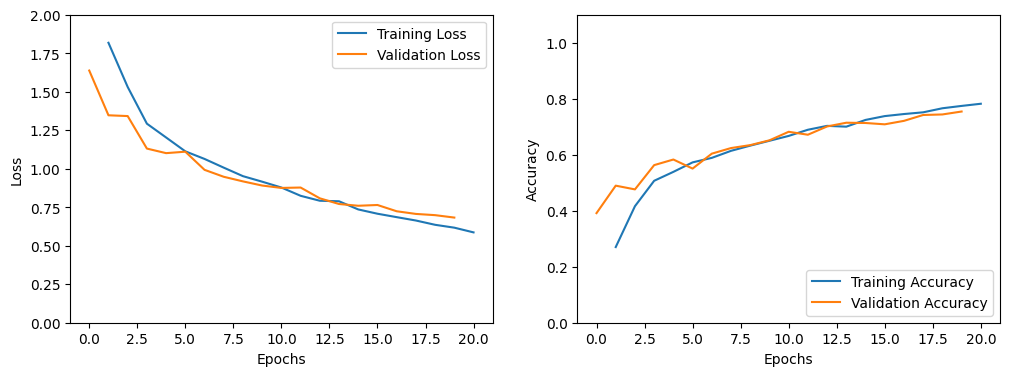

In [23]:
history = pd.read_excel('/kaggle/working/custom_custom_training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [24]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [25]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 19) - Validation Loss: 0.683, Validation Accuracy: 0.754


Best model (from epoch 19) - Validation Loss: 0.683, Validation Accuracy: 0.754


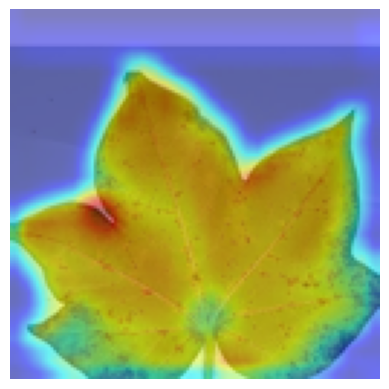

In [26]:
# Grad-CAM
import torch
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path_checkpoints = "/kaggle/working"

# --- Model loading ---
model = CustomCNN(num_classes=num_classes)  # recreate model
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path, map_location=device)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
model = model.to(device)

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

# --- Grad-CAM ---
target_layer = model.features[6]  # last conv layer in CustomCNN
cam = GradCAM(model=model, target_layers=[target_layer])

class_names = [str(i) for i in range(num_classes)]

def visualize_gradcam(image_path, model, cam, class_names):
    rgb_img = np.array(PIL.Image.open(image_path).resize((128, 128))) / 255.0
    
    input_tensor = preprocess_image(
        rgb_img,
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    ).to(device).float()   # ✅ force float32
    
    grayscale_cam = cam(input_tensor=input_tensor)[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    plt.axis('off')
    plt.show()


# Example usage with a test image
example_img_path = test_df.iloc[0]['file_path']
visualize_gradcam(example_img_path, model, cam, class_names)

In [27]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.767
Test Time: 8.04 seconds ---> 0.13 minutes


In [28]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(num_classes)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, num_classes)
for i in range(num_classes):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       150
           1       0.81      0.61      0.70       150
           2       0.59      0.69      0.64       150
           3       0.88      0.91      0.89       150
           4       0.62      0.76      0.68       150
           5       0.90      0.77      0.83       150
           6       0.90      0.87      0.88       150

    accuracy                           0.77      1050
   macro avg       0.78      0.77      0.77      1050
weighted avg       0.78      0.77      0.77      1050

Class 0 Accuracy: 0.753
Class 1 Accuracy: 0.613
Class 2 Accuracy: 0.693
Class 3 Accuracy: 0.907
Class 4 Accuracy: 0.760
Class 5 Accuracy: 0.773
Class 6 Accuracy: 0.867
